<a href="https://colab.research.google.com/github/MohamedShoaib3/Algorithms_python/blob/main/Neural_Networks_Regularization_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Deep Learning Practical Assignment (Adult Income Dataset)

## 📌 Dataset
We will use the **Adult Income dataset** (also known as the Census Income dataset).  
The task is to predict whether a person earns **more than $50K/year** based on demographic and employment attributes.

---


In [3]:
# Option 1: Using OpenML via scikit-learn
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame

print(df.head())
print(df.shape)  # (48842, 15)

# Separate features and target
X = df.drop(columns="class")
y = df["class"]


   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country  class  
0       

## Part 0: Data Preparation
1. Load the dataset into a DataFrame.
2. Split the data into **training, validation, and test sets**.  
   - Suggested: 70% training, 15% validation, 15% test.
3. Apply any necessary preprocessing:
   - Handle categorical features (encoding).
   - Scale numerical features if needed.
4. After training your models, always report results on:
   - **Training accuracy**
   - **Validation accuracy**
   - **Test accuracy**
5. At the end of the assignment, **compare all methods** across train, validation, and test sets.


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

categorical_features = X.select_dtypes(include=["object", "category"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

X_train_pre = preprocessor.fit_transform(X_train)
X_val_pre = preprocessor.transform(X_val)
X_test_pre = preprocessor.transform(X_test)

print("Training set shape:", X_train_pre.shape)
print("Validation set shape:", X_val_pre.shape)
print("Test set shape:", X_test_pre.shape)

Training set shape: (34189, 108)
Validation set shape: (7326, 108)
Test set shape: (7327, 108)



## Part 1: Optimizers
1. Train the same neural network using:
   - Stochastic Gradient Descent (SGD)
   - SGD with Momentum
   - Adam
2. Compare the training and validation accuracy for each optimizer.
3. Which optimizer converges the fastest? Which gives the best generalization?
4. Explain *why* Adam often performs better than plain SGD.

---


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_pre.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_pre.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_pre.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

def train_model(optimizer_name, optimizer_fn, epochs=10):
    model = MLP(input_dim=X_train_tensor.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_fn(model.parameters())

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        val_acc = evaluate(model, val_loader)
        print(f"[{optimizer_name}] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    test_acc = evaluate(model, test_loader)
    print(f"[{optimizer_name}] Final Test Accuracy = {test_acc:.4f}\n")
    return model, train_acc, val_acc, test_acc

print("Training with SGD...")
model_sgd, sgd_train, sgd_val, sgd_test = train_model("SGD", lambda params: optim.SGD(params, lr=0.01), epochs=10)

print("Training with SGD + Momentum...")
model_sgd_mom, mom_train, mom_val, mom_test = train_model("SGD+Momentum", lambda params: optim.SGD(params, lr=0.01, momentum=0.9), epochs=10)

print("Training with Adam...")
model_adam, adam_train, adam_val, adam_test = train_model("Adam", lambda params: optim.Adam(params, lr=0.001), epochs=10)

Training with SGD...
[SGD] Epoch 1: Train Acc=0.7607, Val Acc=0.7607
[SGD] Epoch 2: Train Acc=0.8334, Val Acc=0.8365
[SGD] Epoch 3: Train Acc=0.8392, Val Acc=0.8473
[SGD] Epoch 4: Train Acc=0.8450, Val Acc=0.8534
[SGD] Epoch 5: Train Acc=0.8500, Val Acc=0.8580
[SGD] Epoch 6: Train Acc=0.8523, Val Acc=0.8616
[SGD] Epoch 7: Train Acc=0.8530, Val Acc=0.8602
[SGD] Epoch 8: Train Acc=0.8548, Val Acc=0.8606
[SGD] Epoch 9: Train Acc=0.8546, Val Acc=0.8600
[SGD] Epoch 10: Train Acc=0.8550, Val Acc=0.8610
[SGD] Final Test Accuracy = 0.8581

Training with SGD + Momentum...
[SGD+Momentum] Epoch 1: Train Acc=0.8536, Val Acc=0.8586
[SGD+Momentum] Epoch 2: Train Acc=0.8537, Val Acc=0.8589
[SGD+Momentum] Epoch 3: Train Acc=0.8551, Val Acc=0.8631
[SGD+Momentum] Epoch 4: Train Acc=0.8563, Val Acc=0.8604
[SGD+Momentum] Epoch 5: Train Acc=0.8524, Val Acc=0.8572
[SGD+Momentum] Epoch 6: Train Acc=0.8550, Val Acc=0.8576
[SGD+Momentum] Epoch 7: Train Acc=0.8572, Val Acc=0.8612
[SGD+Momentum] Epoch 8: Train A

## Part 2: Batch Size
1. Train the same model with different batch sizes (e.g., 1, 32, 128, 1024).
2. Compare:
   - Training speed
   - Validation accuracy
   - Test accuracy
   - Generalization ability
3. Which batch size leads to the **noisiest gradient updates**?
4. Which batch size generalizes better and why?

In [15]:
def train_with_batchsize(batch_size, epochs=5):
    print(f"\nTraining with batch size = {batch_size}...")

    train_loader_bsz = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader_bsz   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    test_loader_bsz  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

    model = MLP(input_dim=X_train_tensor.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader_bsz:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader_bsz)
        val_acc = evaluate(model, val_loader_bsz)
        print(f"[Batch={batch_size}] Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    test_acc = evaluate(model, test_loader_bsz)
    print(f"[Batch={batch_size}] Final Test Accuracy = {test_acc:.4f}")
    return train_acc, val_acc, test_acc


batch_sizes = [1, 32, 128, 1024]
results_bsz = {}

for bsz in batch_sizes:
    train_acc, val_acc, test_acc = train_with_batchsize(bsz, epochs=5)
    results_bsz[bsz] = (train_acc, val_acc, test_acc)

print("\n=== Final Comparison (Batch Size vs Accuracy) ===")
for bsz, (tr, va, te) in results_bsz.items():
    print(f"Batch {bsz}: Train={tr:.4f}, Val={va:.4f}, Test={te:.4f}")


Training with batch size = 1...
[Batch=1] Epoch 1: Train Acc=0.8569, Val Acc=0.8627
[Batch=1] Epoch 2: Train Acc=0.8585, Val Acc=0.8605
[Batch=1] Epoch 3: Train Acc=0.8582, Val Acc=0.8628
[Batch=1] Epoch 4: Train Acc=0.8605, Val Acc=0.8661
[Batch=1] Epoch 5: Train Acc=0.8624, Val Acc=0.8643
[Batch=1] Final Test Accuracy = 0.8605

Training with batch size = 32...
[Batch=32] Epoch 1: Train Acc=0.8566, Val Acc=0.8616
[Batch=32] Epoch 2: Train Acc=0.8588, Val Acc=0.8598
[Batch=32] Epoch 3: Train Acc=0.8610, Val Acc=0.8619
[Batch=32] Epoch 4: Train Acc=0.8610, Val Acc=0.8650
[Batch=32] Epoch 5: Train Acc=0.8633, Val Acc=0.8632
[Batch=32] Final Test Accuracy = 0.8605

Training with batch size = 128...
[Batch=128] Epoch 1: Train Acc=0.8534, Val Acc=0.8610
[Batch=128] Epoch 2: Train Acc=0.8576, Val Acc=0.8616
[Batch=128] Epoch 3: Train Acc=0.8605, Val Acc=0.8636
[Batch=128] Epoch 4: Train Acc=0.8598, Val Acc=0.8643
[Batch=128] Epoch 5: Train Acc=0.8607, Val Acc=0.8643
[Batch=128] Final Test A


## Part 3: Overfitting and Regularization
1. Train a large neural network (many parameters) on the dataset.
2. Observe training vs. validation accuracy.  
   - Do you see signs of overfitting?
3. Apply regularization techniques:
   - **L2 regularization**
   - **Dropout**
4. Compare the validation results before and after regularization.
5. Which regularization method was more effective in reducing overfitting? Why?

---


In [16]:
class LargeNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LargeNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)


def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        correct_train, total_train = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)
        train_acc = correct_train / total_train

        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y_batch).sum().item()
                total_val += y_batch.size(0)
        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")


print("\n=== Large NN WITHOUT Regularization ===")
model_no_reg = LargeNN(X_train_tensor.shape[1], len(torch.unique(y_train_tensor)))
optimizer = optim.Adam(model_no_reg.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_and_evaluate(model_no_reg, optimizer, criterion, train_loader, val_loader)


print("\n=== Large NN WITH L2 Regularization ===")
model_l2 = LargeNN(X_train_tensor.shape[1], len(torch.unique(y_train_tensor)))
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-4)
train_and_evaluate(model_l2, optimizer_l2, criterion, train_loader, val_loader)


class LargeNN_Dropout(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LargeNN_Dropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 50% dropout

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        return self.fc4(x)

print("\n=== Large NN WITH Dropout ===")
model_dropout = LargeNN_Dropout(X_train_tensor.shape[1], len(torch.unique(y_train_tensor)))
optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=0.001)
train_and_evaluate(model_dropout, optimizer_dropout, criterion, train_loader, val_loader)


=== Large NN WITHOUT Regularization ===
Epoch 1: Train Acc=0.8480, Val Acc=0.8575
Epoch 2: Train Acc=0.8561, Val Acc=0.8621
Epoch 3: Train Acc=0.8584, Val Acc=0.8625
Epoch 4: Train Acc=0.8616, Val Acc=0.8654
Epoch 5: Train Acc=0.8636, Val Acc=0.8631
Epoch 6: Train Acc=0.8650, Val Acc=0.8617
Epoch 7: Train Acc=0.8693, Val Acc=0.8638
Epoch 8: Train Acc=0.8737, Val Acc=0.8609
Epoch 9: Train Acc=0.8762, Val Acc=0.8606
Epoch 10: Train Acc=0.8786, Val Acc=0.8589

=== Large NN WITH L2 Regularization ===
Epoch 1: Train Acc=0.8485, Val Acc=0.8610
Epoch 2: Train Acc=0.8550, Val Acc=0.8643
Epoch 3: Train Acc=0.8583, Val Acc=0.8636
Epoch 4: Train Acc=0.8582, Val Acc=0.8597
Epoch 5: Train Acc=0.8607, Val Acc=0.8616
Epoch 6: Train Acc=0.8629, Val Acc=0.8647
Epoch 7: Train Acc=0.8639, Val Acc=0.8639
Epoch 8: Train Acc=0.8651, Val Acc=0.8651
Epoch 9: Train Acc=0.8667, Val Acc=0.8670
Epoch 10: Train Acc=0.8679, Val Acc=0.8630

=== Large NN WITH Dropout ===
Epoch 1: Train Acc=0.8439, Val Acc=0.8597
Epo

## Part 4: Early Stopping
1. Train the model for many epochs without early stopping.  
   - Plot training, validation, and test curves.
2. Train again with **early stopping** (monitor validation loss).
3. Compare the number of epochs trained and the final validation/test accuracy.
4. Explain how early stopping helps prevent overfitting.

---

Training WITHOUT Early Stopping...
Epoch 1: Train Acc=0.8559, Val Acc=0.8575
Epoch 2: Train Acc=0.8571, Val Acc=0.8600
Epoch 3: Train Acc=0.8593, Val Acc=0.8609
Epoch 4: Train Acc=0.8615, Val Acc=0.8630
Epoch 5: Train Acc=0.8625, Val Acc=0.8636
Epoch 6: Train Acc=0.8645, Val Acc=0.8647
Epoch 7: Train Acc=0.8643, Val Acc=0.8632
Epoch 8: Train Acc=0.8663, Val Acc=0.8630
Epoch 9: Train Acc=0.8666, Val Acc=0.8664
Epoch 10: Train Acc=0.8648, Val Acc=0.8615
Epoch 11: Train Acc=0.8710, Val Acc=0.8640
Epoch 12: Train Acc=0.8706, Val Acc=0.8621
Epoch 13: Train Acc=0.8708, Val Acc=0.8606
Epoch 14: Train Acc=0.8738, Val Acc=0.8639
Epoch 15: Train Acc=0.8727, Val Acc=0.8646
Epoch 16: Train Acc=0.8753, Val Acc=0.8620
Epoch 17: Train Acc=0.8744, Val Acc=0.8586
Epoch 18: Train Acc=0.8764, Val Acc=0.8625
Epoch 19: Train Acc=0.8782, Val Acc=0.8579
Epoch 20: Train Acc=0.8798, Val Acc=0.8604
Epoch 21: Train Acc=0.8791, Val Acc=0.8600
Epoch 22: Train Acc=0.8805, Val Acc=0.8619
Epoch 23: Train Acc=0.8818, 

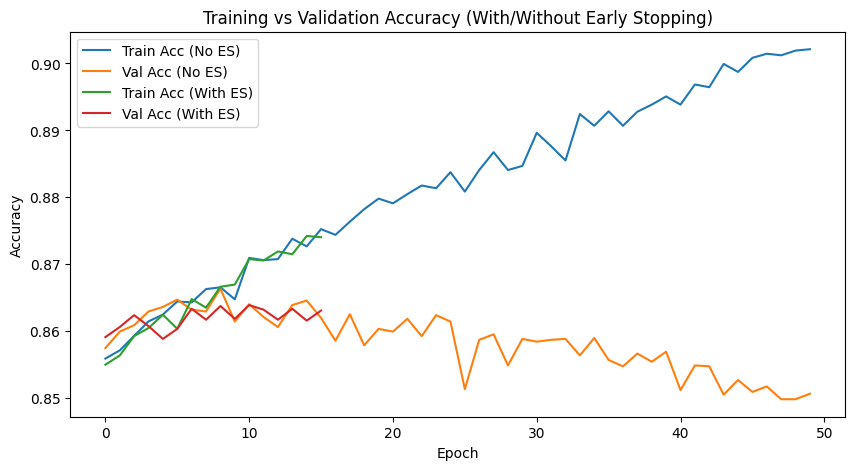


Final Test Accuracy WITHOUT Early Stopping: 0.8447
Final Test Accuracy WITH Early Stopping: 0.8563


In [17]:
import matplotlib.pyplot as plt
def train_with_early_stopping(model, optimizer, criterion,
                              train_loader, val_loader, test_loader,
                              max_epochs=50, patience=5, use_early_stopping=False):

    train_accs, val_accs = [], []
    best_val_acc = 0
    best_model_state = None
    wait = 0

    for epoch in range(max_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        train_acc = evaluate(model, train_loader)
        val_acc = evaluate(model, val_loader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if use_early_stopping:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

    if use_early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state)

    test_acc = evaluate(model, test_loader)
    return train_accs, val_accs, test_acc


model_no_es = MLP(input_dim=X_train_tensor.shape[1])
optimizer = optim.Adam(model_no_es.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training WITHOUT Early Stopping...")
train_accs_no_es, val_accs_no_es, test_acc_no_es = train_with_early_stopping(
    model_no_es, optimizer, criterion,
    train_loader, val_loader, test_loader,
    max_epochs=50, use_early_stopping=False
)


model_es = MLP(input_dim=X_train_tensor.shape[1])
optimizer = optim.Adam(model_es.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("\nTraining WITH Early Stopping...")
train_accs_es, val_accs_es, test_acc_es = train_with_early_stopping(
    model_es, optimizer, criterion,
    train_loader, val_loader, test_loader,
    max_epochs=50, patience=5, use_early_stopping=True
)


plt.figure(figsize=(10,5))
plt.plot(train_accs_no_es, label="Train Acc (No ES)")
plt.plot(val_accs_no_es, label="Val Acc (No ES)")
plt.plot(train_accs_es, label="Train Acc (With ES)")
plt.plot(val_accs_es, label="Val Acc (With ES)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (With/Without Early Stopping)")
plt.show()

print(f"\nFinal Test Accuracy WITHOUT Early Stopping: {test_acc_no_es:.4f}")
print(f"Final Test Accuracy WITH Early Stopping: {test_acc_es:.4f}")

## Part 5: Reflection
1. Summarize what you learned about:
   - The role of optimizers
   - The effect of batch size
   - Regularization methods
   - Early stopping
   - Train/validation/test splits
2. If you had to train a deep learning model on a new tabular dataset, what choices would you make for:
   - Optimizer
   - Batch size
   - Regularization
   - Early stopping
   - Data splitting strategy  
   and why?

## Part 5: Reflection

### What I Learned
- **Optimizers**: Optimizers like SGD, Adam, etc. control how the model updates weights. Adam often converges faster and more stably, while plain SGD can be slower but may generalize better in some cases.  
- **Batch Size**: Small batch sizes give noisier updates but can improve generalization. Large batches train faster but may overfit or get stuck in sharp minima.  
- **Regularization Methods**: Techniques like L2 regularization and Dropout prevent overfitting by discouraging overly complex models. L2 keeps weights small, while Dropout forces neurons not to rely on each other too much.  
- **Early Stopping**: By monitoring validation loss, training stops before overfitting happens. This saves time and improves generalization.  
- **Train/Validation/Test Splits**: Proper splitting is essential. Training is for fitting the model, validation for tuning hyperparameters, and test for unbiased evaluation.

### My Choices for a New Tabular Dataset
- **Optimizer**: Adam — because it adapts learning rates and usually gives fast, stable convergence.  
- **Batch Size**: Medium size (e.g., 32 or 64) — balances noisy updates (good generalization) with efficiency.  
- **Regularization**: L2 regularization + Dropout — helps control overfitting, especially on high-dimensional tabular data.  
- **Early Stopping**: Yes, monitor validation loss — to avoid wasting epochs and to stop before overfitting.  
- **Data Splitting Strategy**: Use 70% train, 15% validation, 15% test (or k-fold cross-validation if data is small) — ensures fair evaluation and reliable tuning.